In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

El objetivo es 'predecir' si un estudiante será admitido en una universidad, en función de su GMAT (Graduate Management Admission Test), puntajes de GPA (Grade Point Average), y su experiencia laboral. La variable dependiente aquí es una variable logística binaria, que se espera que adopte estrictamente una de dos formas, i.e., admitido o no admitido.

In [6]:
df = pd.read_csv('logit_train - logit_train.csv', index_col = 0)
df.describe()

,gmat,gpa,work_experience,admitted
count,30.000000,30.000000,30.000000,30.000000
mean,650.000000,3.150000,3.666667,0.500000
std,63.734363,0.664234,1.667816,0.508548
min,540.000000,1.700000,1.000000,0.000000
25%,590.000000,2.700000,2.000000,0.000000
50%,660.000000,3.300000,4.000000,0.500000
75%,690.000000,3.700000,5.000000,1.000000
max,780.000000,4.000000,6.000000,1.000000


### Partición de los datos
X_train para el vector de características y y_train para las etiquetas. Se muestran los primeros valores para cada dataframe.

In [9]:
X_train = df[['gmat', 'gpa', 'work_experience']]
y_train = df[['admitted']]

print(X_train.head())
print(y_train.head())

    gmat  gpa  work_experience
16   580  2.7                4
33   660  3.3                6
8    740  3.3                5
38   590  1.7                4
32   660  4.0                4
    admitted
16         0
33         1
8          1
38         0
32         1


### Análisis exploratorio

Se realizó un análisis exploratorio de los datos, visualizando las relaciones entre las variables numéricas. Inicialmente, se exploró la relación entre la variable binaria 'admitted' y el resto de las variables numéricas mediante gráficos de dispersión con una línea de regresión lineal simple.

Sin embargo, es importante notar que la regresión lineal simple no es el modelo más adecuado para predecir una variable binaria, ya que asume una relación lineal entre las variables y una distribución normal de los residuos, lo cual no se cumple en este caso.

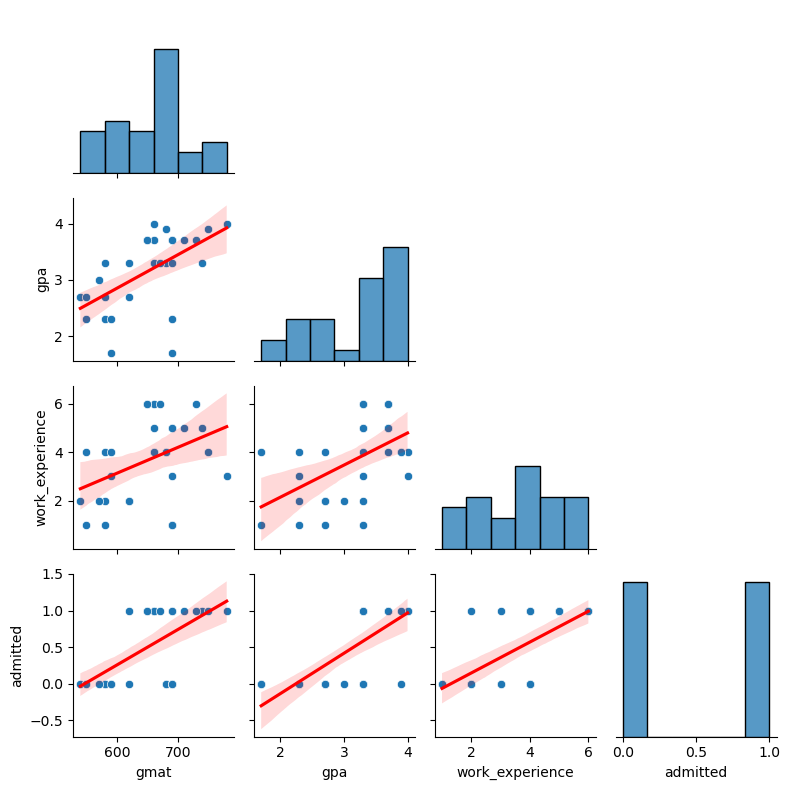

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

school_pairplot = sns.pairplot(df, height=2, aspect=1, corner=True)

def regline(x, y, **kwargs):
    sns.regplot(data=kwargs['data'], x=x.name, y=y.name, scatter=False, color=kwargs['color'])

school_pairplot.map_offdiag(regline, color='red', data=df)

plt.tight_layout()
plt.show()

### Generación del modelo de Regresión Logística
Statsmodels es un módulo de Python que proporciona varias funciones para estimar diferentes modelos estadísticos y realizar pruebas estadísticas.

Primero, se define el conjunto de variables dependientes (y) e independientes (X). Si la variable dependiente está en forma no numérica, se convierte. Statsmodels proporciona la función Logit() para realizar regresión logística. La función Logit() acepta y y X como parámetros y devuelve el objeto Logit. Luego se ajusta el modelo a los datos.

In [17]:
# building the model and fitting the data
log_reg = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.352707
         Iterations 8


En el resultado, 'Iterations' se refiere a la cantidad de veces que el modelo itera sobre los datos, tratando de optimizar el modelo. De forma predeterminada, el número máximo de iteraciones realizadas es 35, tras lo cual la optimización termina.

## Mostrar los resultados del modelo


In [21]:
# printing the summary table
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:               admitted   No. Observations:                   30
Model:                          Logit   Df Residuals:                       27
Method:                           MLE   Df Model:                            2
Date:                Mon, 30 Sep 2024   Pseudo R-squ.:                  0.4912
Time:                        12:54:40   Log-Likelihood:                -10.581
converged:                       True   LL-Null:                       -20.794
Covariance Type:            nonrobust   LLR p-value:                 3.668e-05
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
gmat               -0.0262      0.011     -2.383      0.017      -0.048      -0.005
gpa                 3.9422      1.964      2.007      0.045       0.092       7.792
work_experience     1.1983      

donde

coef: los coeficientes de las variables independientes en la ecuación de regresión. Log-Likelihood: el logaritmo natural de la función de estimación de máxima verosimilitud (MLE). MLE es el proceso de optimización para encontrar el conjunto de parámetros que resulten en el mejor ajuste. LL-Null: el valor de Log-Likelihood del modelo cuando no se incluye ninguna variable independiente (solo se incluye una intersección). Pseudo R-squ.: un sustituto del valor de R cuadrado en la regresión lineal de mínimos cuadrados. Es la relación entre la probabilidad logarítmica del modelo nulo y la del modelo completo.

### Predicción sobre nuevos datos
Ahora el modelo se usará con nuevos datos. La función predict() se utiliza para las predicciones. Las predicciones obtenidas son valores fraccionarios (entre 0 y 1) que denotan la probabilidad de ser admitido. Por lo tanto, estos valores se redondean para obtener valores discretos de 1 o 0.

In [24]:
# loading the testing dataset  
df = pd.read_csv('logit_test - logit_test.csv', index_col = 0)
  
# defining the dependent and independent variables
X_test = df[['gmat', 'gpa', 'work_experience']]
y_test = df['admitted']
  
# performing predictions on the test dataset
y_hat = log_reg.predict(X_test)
prediction = list(map(round, y_hat))
print('y_hat:\n', y_hat)
  
# comparing original and predicted values of y
print('Actual values', list(y_test.values))
print('Predictions :', prediction)

y_hat:
 35    0.001178
36    0.011084
30    0.023620
10    0.151511
21    0.001335
7     0.261632
14    0.028082
15    0.050366
34    0.769849
12    0.960745
dtype: float64
Actual values [0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
Predictions : [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]


### ¿Qué tan bueno es el modelo?
Comparemos las predicciones realizadas por el modelo vs. las etiquetas verdaderas construyendo una matriz de confusión y calculando una métrica de rendimiento global. Se definen dos funciones principales: crear_matriz_confusion: 
* Creaate_confusion_matriz: matriz de confusión iterando sobre las etiquetas verdaderas y predicciones.
* Calcular_metricas: Calcula las métricas de evaluación a partir de la matriz de confusión.

Importante mencionar que es un problema binario, así que la matriz de confusión es de 2x2.

In [29]:
def create_confusion_matrix(y_true, y_pred):
    # Crear una matriz de confusión de 2x2 inicializada en ceros
    confusion_matrix = np.zeros((2, 2), dtype=int)

    # Iterar sobre las etiquetas verdaderas y predicciones para actualizar la matriz
    for i in range(len(y_true)):
        confusion_matrix[y_true[i], y_pred[i]] += 1

    return confusion_matrix

def calculate_accuracy(confusion_matrix):
    # TP: Verdaderos positivos (estudiantes admitidos que fueron correctamente clasificados como admitidos).
    TP = confusion_matrix[1, 1]
    # TN: Verdaderos negativos (estudiantes no admitidos que fueron correctamente clasificados como no admitidos).
    TN = confusion_matrix[0, 0]
    # FP: Falsos positivos (estudiantes no admitidos que fueron incorrectamente clasificados como admitidos).
    FP = confusion_matrix[0, 1]
    # FN: Falsos negativos (estudiantes admitidos que fueron incorrectamente clasificados como no admitidos).
    FN = confusion_matrix[1, 0]

    accuracy = (TP + TN) / (TP + TN + FP + FN)

    return accuracy


In [31]:
# Confusion matrix from predicitions
cm = create_confusion_matrix(y_test.values, prediction)
print("Confusion Matrix:\n", cm)

# accuracy score of the model
print('Test accuracy = ', calculate_accuracy(cm))

Confusion Matrix:
 [[6 0]
 [2 2]]
Test accuracy =  0.8


Esto indica que de cada 5 analisis predicirá correctamente 4. 

# Ahora con Scikit-learn


In [37]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train, y_train.values.ravel())

LogisticRegression()

In [39]:
y_pred = logreg.predict(X_test)

# comparing original and predicted values of y
print('Actual values', list(y_test.values))
print('Predictions :', y_pred)

Actual values [0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
Predictions : [0 0 0 0 0 1 1 0 1 1]


In [42]:
from sklearn.metrics import (confusion_matrix, accuracy_score)
  
# confusion matrix
cm = confusion_matrix(y_test, y_pred) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, y_pred))

Confusion Matrix : 
 [[6 0]
 [0 4]]
Test accuracy =  1.0


Esto indica que es capáz de predecir correctamente todos los valores